![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

<div class="alert alert-warning">
This notebook still needs to go through revision.
</div>

# DMD analysis of 2D transonic shock buffets on a NACA-0012 airfoil

In [1]:
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from stl import mesh
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.analysis.dmd import DMD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Test cases
Two simulations are used in this DMD analysis:
1. a steady reference simulation at $\alpha = 2$ showing no buffet
2. a transient simulation at $\alpha = 4$ displaying shock buffet oscillations

In [2]:
no_buffet_case = "../../../test/test_data/run/naca0012_alpha2_2D_nobuffet/"
buffet_case = "../../../test/test_data/run/naca0012_alpha4_2D_buffet/"

## Assembling different data matrices
### Creating a mask

Make sure to compute the cell centers and volumes before loading the data. If no pre-computed fields are available, the geometry is computed within *flowTorch*, and this computation is significantly slower than the one in *OpenFOAM*. The cell volumes won't be used in this tutorial, but *flowTorch* will compute or load them by default. Moreover, it is recommendable to reconstruct parallel cases first.
```
postProcess -func writeCellCentres -constant -time none
postProcess -func writeCellVolumes -constant -time none
```

In [3]:
ref_loader = FOAMDataloader(no_buffet_case)
vertices = ref_loader.get_vertices()[:, :2]  # discard z-coordinate
mask = mask_box(vertices, lower=[-0.1, -0.2], upper=[3, 0.8])

selected_rel = "{:2.2f}%".format(mask.sum().item()/mask.shape[0]*100)
print(f"Selected vertices: {mask.sum().item()}/{mask.shape[0]} ({selected_rel})")

Loading precomputed cell centers and volumes from constant/
Selected vertices: 219121/369600 (59.29%)


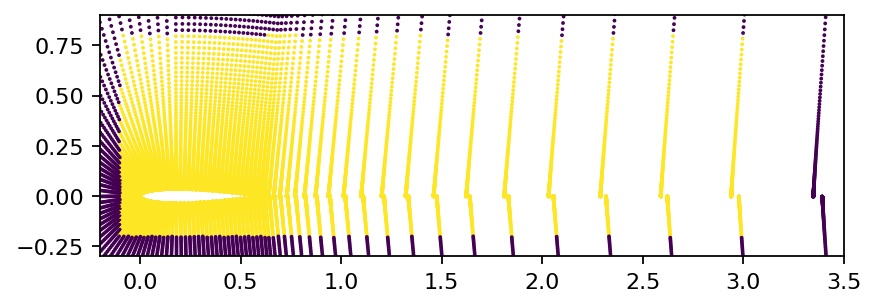

In [4]:
every = 10 # show only every 10th vertex
fig, ax = plt.subplots()
ax.scatter(vertices[::every, 0], vertices[::every, 1], s=0.5, c=mask[::every])
ax.set_aspect("equal", 'box')
ax.set_xlim(-0.2, 3.5)
ax.set_ylim(-0.3, 0.9)
plt.show()

## Various types of data matrices

In the transient simulation, we only use snapshots in the time range $0.127s \le t \le 0.239$, which cover about buffet cycles.

In [5]:
loader = FOAMDataloader(buffet_case)
times = loader.write_times()
window_times = [time for time in times if 0.239 >= float(time) >= 0.127]
fields = loader.field_names()
print(f"Number of available snapshots: {len(times)}")
print(f"Number of selected snapshots: {len(window_times)}")
print("First five write times: ", times[:5])
print(f"Fields available at t={times[-1]}: ", fields[times[-1]])

Number of available snapshots: 250
Number of selected snapshots: 113
First five write times:  ['0.001', '0.002', '0.003', '0.004', '0.005']
Fields available at t=0.25:  ['alphat', 'rho', 'div(U)', 'total(p)_coeff', 'p', 'nuTilda', 'T', 'vorticity', 'phi', 'Ma', 'DESField', 'nut', 'U']


In [6]:
# number of masked points
n_mask = mask.sum().item()

# dictionary to collect data matrices
data_matrices = {}
data_matrices["rho"] = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float32)
data_matrices["vorticity"] = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float32)
data_matrices["U"] = pt.zeros((n_mask*2, len(window_times)), dtype=pt.float32)
data_matrices["U_base"] = pt.zeros((n_mask*2, len(window_times)), dtype=pt.float32)

# load baseflow veloctiy field, discard z-component
U_base = ref_loader.load_snapshot("U", "0.25")[:, :2]

for i, time in enumerate(window_times):
    data_matrices["rho"][:, i] = pt.masked_select(loader.load_snapshot("rho", time), mask)
    # the vorticity field contains some outlier, which we clip before adding the field to the data matrix
    vorticity = pt.clamp(loader.load_snapshot("vorticity", time)[:, 2], -1.0e3, 1.0e3)
    data_matrices["vorticity"][:, i] = pt.masked_select(vorticity, mask)
    # the velocity is a vectorial quantity; we stack the u and v component on top of one another in column of the data matrix
    # since both components are very different in magnitude, we normalize them to the range [-1, 1]
    U = loader.load_snapshot("U", time)[:, :2]
    data_matrices["U"][:n_mask, i] = pt.masked_select(U[:, 0], mask)
    data_matrices["U"][n_mask:, i] = pt.masked_select(U[:, 1], mask)
    U_rel = U - U_base
    data_matrices["U_base"][:n_mask, i] = pt.masked_select(U_rel[:, 0], mask)
    data_matrices["U_base"][n_mask:, i] = pt.masked_select(U_rel[:, 1], mask)
    
# uncomment to subtract temporal mean
#for key in data_matrices.keys():
#    data_matrices[key] -= pt.mean(data_matrices[key], dim=1).unsqueeze(-1)

In [7]:
# normalize the U/U_base data matrices to the range [0, 1]
def normalize_velocity_2D(dm):
    U_x_min = dm[:n_mask, :].min()
    U_x_max = dm[:n_mask, :].max()
    U_y_min = dm[n_mask:, :].min()
    U_y_max = dm[n_mask:, :].max()
    dm[:n_mask, :] = (dm[:n_mask, :] - U_x_min) / (U_x_max - U_x_min)
    dm[n_mask:, :] = (dm[n_mask:, :] - U_y_min) / (U_y_max - U_y_min)
    return dm

# normalize all other data matrices to the range [0, 1]
def normalize_1D(dm):
    return (dm - dm.min())/(dm.max()-dm.min())

data_matrices["U"] = normalize_velocity_2D(data_matrices["U"])
data_matrices["U_base"] = normalize_velocity_2D(data_matrices["U_base"])
data_matrices["rho"] = normalize_1D(data_matrices["rho"])
data_matrices["vorticity"] = normalize_1D(data_matrices["vorticity"])

In [8]:
# check if the normalization worked
for key in data_matrices.keys():
    print(key, data_matrices[key].min().item(), data_matrices[key].max().item())

rho 0.0 1.0
vorticity 0.0 1.0
U 0.0 1.0
U_base 0.0 1.0


## Singular values

Before computing the DMD, we have a look at the singular values to know how much to truncate. For all fields expect for vorticity, a rank of $20$ is sufficient to explain about $90\%$ of the variance in the data.

In [9]:
svals = dict()
svals_cum = dict()
for key in data_matrices.keys():
    _, s, _ = pt.linalg.svd(data_matrices[key], full_matrices=False)
    svals[key] = s
    svals_cum[key] = [s[:n].sum()/s.sum()*100 for n in range(s.shape[0])]

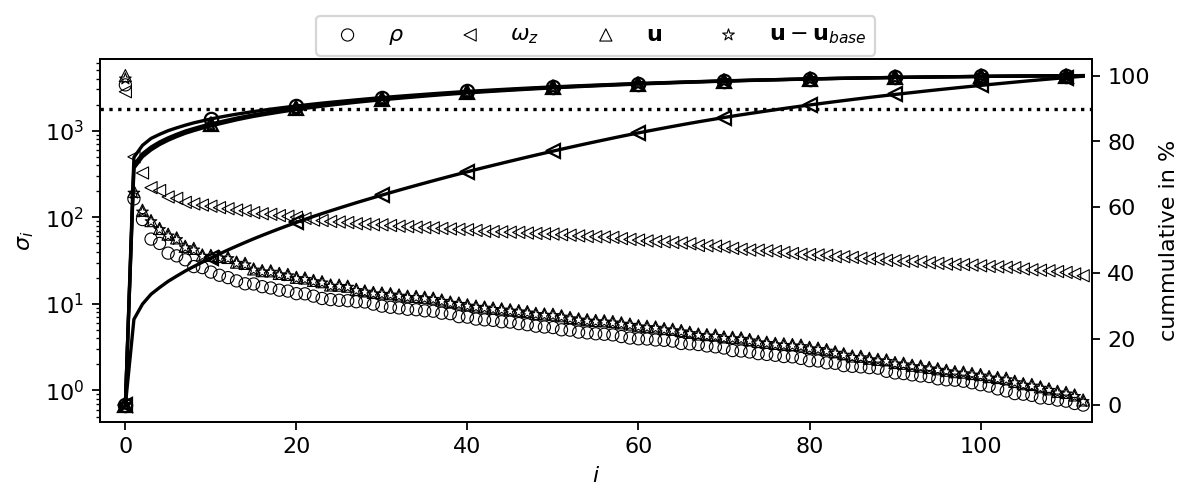

In [10]:
fig, ax = plt.subplots(figsize=(8,3))
ax_sum = ax.twinx()

markers = ["o", "<", "^", "*"]
labels = [r"$\rho$", r"$\omega_z$", r"$\mathbf{u}$", r"$\mathbf{u}-\mathbf{u}_{base}$"]

for i, key in enumerate(svals.keys()):
    ax.scatter(range(len(window_times)), svals[key], marker=markers[i], s=30, lw=0.5, edgecolor="k", facecolors='none', label=labels[i])
    ax_sum.plot(range(len(window_times)), svals_cum[key], marker=markers[i], markerfacecolor="None", c="k", markevery=10)
    

ax.set_yscale("log")
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\sigma_i$")
ax.set_xlim(-3, len(window_times))
ax.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=len(svals.keys()))
ax_sum.set_ylabel("cummulative in %")
ax_sum.axhline(90, ls=":", color="k")
plt.savefig("singular_values.pdf", bbox_inches="tight")
plt.show()

## DMD analysis

In [11]:
dmd = {}
ranks = [20, 20, 20, 20]
for i, key in enumerate(data_matrices.keys()):
    dmd[key] = DMD(data_matrices[key], rank=ranks[i])

In [12]:
for key in dmd.keys():
    print(key, dmd[key])
    print("-"*30)

rho SVD:
SVD of a 219121x112 data matrix
Selected/optimal rank: 20/44
data type: torch.float32 (4b)
truncated SVD size: 16.7262Mb
LSQ:
Overall DMD size: 50.1646Mb
------------------------------
vorticity SVD:
SVD of a 219121x112 data matrix
Selected/optimal rank: 20/27
data type: torch.float32 (4b)
truncated SVD size: 16.7262Mb
LSQ:
Overall DMD size: 50.1646Mb
------------------------------
U SVD:
SVD of a 438242x112 data matrix
Selected/optimal rank: 20/43
data type: torch.float32 (4b)
truncated SVD size: 33.4438Mb
LSQ:
Overall DMD size: 100.3175Mb
------------------------------
U_base SVD:
SVD of a 438242x112 data matrix
Selected/optimal rank: 20/43
data type: torch.float32 (4b)
truncated SVD size: 33.4438Mb
LSQ:
Overall DMD size: 100.3175Mb
------------------------------


### Eigenvalues

The eigen values tell us about the stability of the corresponding mode. Eigen values located on the unit circle indicate a stable behavior over time. Eigen values inside the circle are damped, and values outside the circle are amplified. The mode on the unit circle with zero imaginary part is a constant background mode.

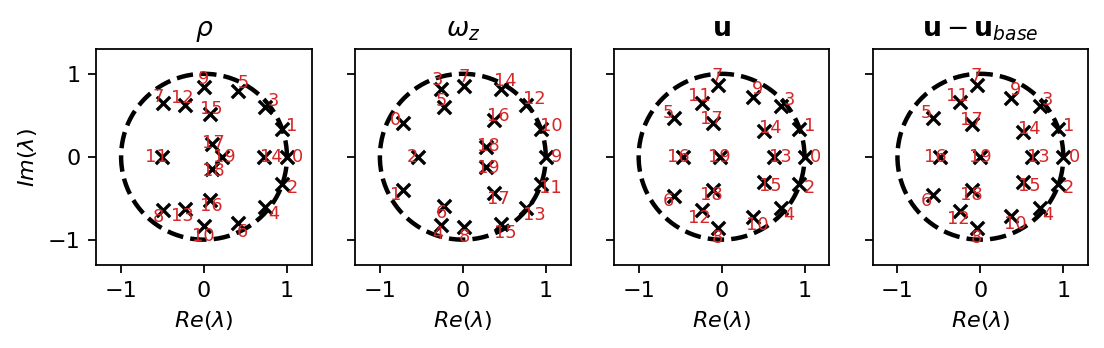

In [13]:
fig, axarr = plt.subplots(1, len(dmd.keys()), figsize=(8, 3), sharex=True, sharey=True)

t = pt.linspace(0, 2 * np.pi, 100)

for i, key in enumerate(dmd.keys()):
    axarr[i].plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
    axarr[i].scatter(dmd[key].eigvals.real, dmd[key].eigvals.imag, marker="x", color="k")
    for j, val in enumerate(dmd[key].eigvals):
        axarr[i].annotate(f"{j}", (val.real*1.13, val.imag*1.13), ha='center', va="center", fontsize=8, zorder=6, color="C3")
    axarr[i].set_title(labels[i])
    axarr[i].set_xlim(-1.3, 1.3)
    axarr[i].set_ylim(-1.3, 1.3)
    axarr[i].set_xlabel(r"$Re(\lambda)$")
    axarr[i].set_aspect("equal")
    
axarr[0].set_ylabel(r"$Im(\lambda)$")

plt.savefig("dmd_eigenvalues.pdf", bbox_inches="tight")
plt.show()

### Spectrum

Now we look at the frequency spectrum. The markers in the plot are scaled by the mode's magnitude (a larger marker indicates that a mode contributes more to the variance in the data.). The buffet frequency is clearly visible in all fields (about $53Hz$, mode 10 for vorticity and mode 1 for all other fields).

First four frequencies:  tensor([ 53.9548, 108.9166, 173.6221, 353.7146])
First four frequencies:  tensor([-418.5564,  300.2686,  308.8127,  247.8107])
First four frequencies:  tensor([ 53.9708, 112.3773, 390.0218, 257.8626])
First four frequencies:  tensor([ 53.9792, 112.7164, 391.4135, 258.2655])


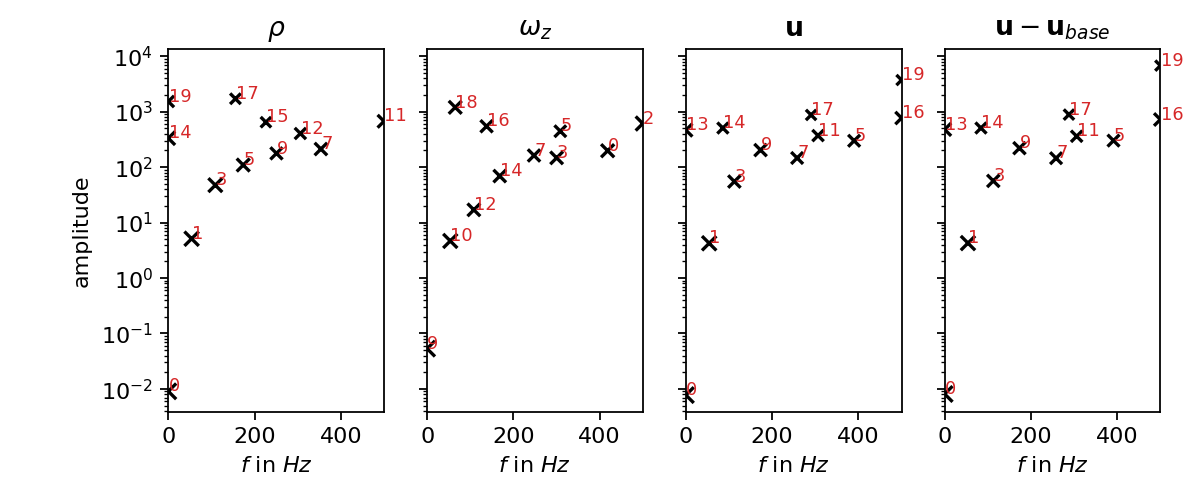

In [14]:
fig, axarr = plt.subplots(1, len(dmd.keys()), figsize=(8, 3), sharex=True, sharey=True)
for i, key in enumerate(dmd.keys()):
    amplitude, frequency = dmd[key].spectrum(dt = 0.001)
    mode_norm = pt.linalg.norm(dmd[key].modes.real, dim=0)
    axarr[i].scatter(frequency, amplitude.abs(), marker="x", c="k", s=mode_norm*50)
    print("First four frequencies: ", frequency[1:9:2])
    for j, (a, f) in enumerate(zip(amplitude, frequency)):
        axarr[i].annotate(f"{j}", (f+0.5, a.abs()), fontsize=8, c="C3")

    axarr[i].set_xlabel(r"$f$ in $Hz$")
    axarr[i].set_title(labels[i])
axarr[0].set_xlim(0, 500)
axarr[0].set_yscale("log")
axarr[0].set_ylabel(r"amplitude")
plt.savefig("dmd_spectrum.pdf", bbox_inches="tight")
plt.show()

### Modes

To plot the STL geometry, install *numpy-stl*, e.g, by running:
```
pip3 install numpy-stl
```

In [15]:
naca_stl = mesh.Mesh.from_file(buffet_case + "constant/geometry/naca0012.stl")

def add_naca0012_patch(axis, scale=0.6):
    x_up = naca_stl.x[naca_stl.y > 0] * scale
    y_up = naca_stl.y[naca_stl.y > 0] * scale
    x_low = naca_stl.x[naca_stl.y < 0] * scale
    y_low = naca_stl.y[naca_stl.y < 0] * scale
    axis.fill_between(x_up, 0.0, y_up, color="k")
    axis.fill_between(x_low, y_low, 0.0, color="k")
    
x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)
every = 4

#### Mean and buffet mode for different data matrices

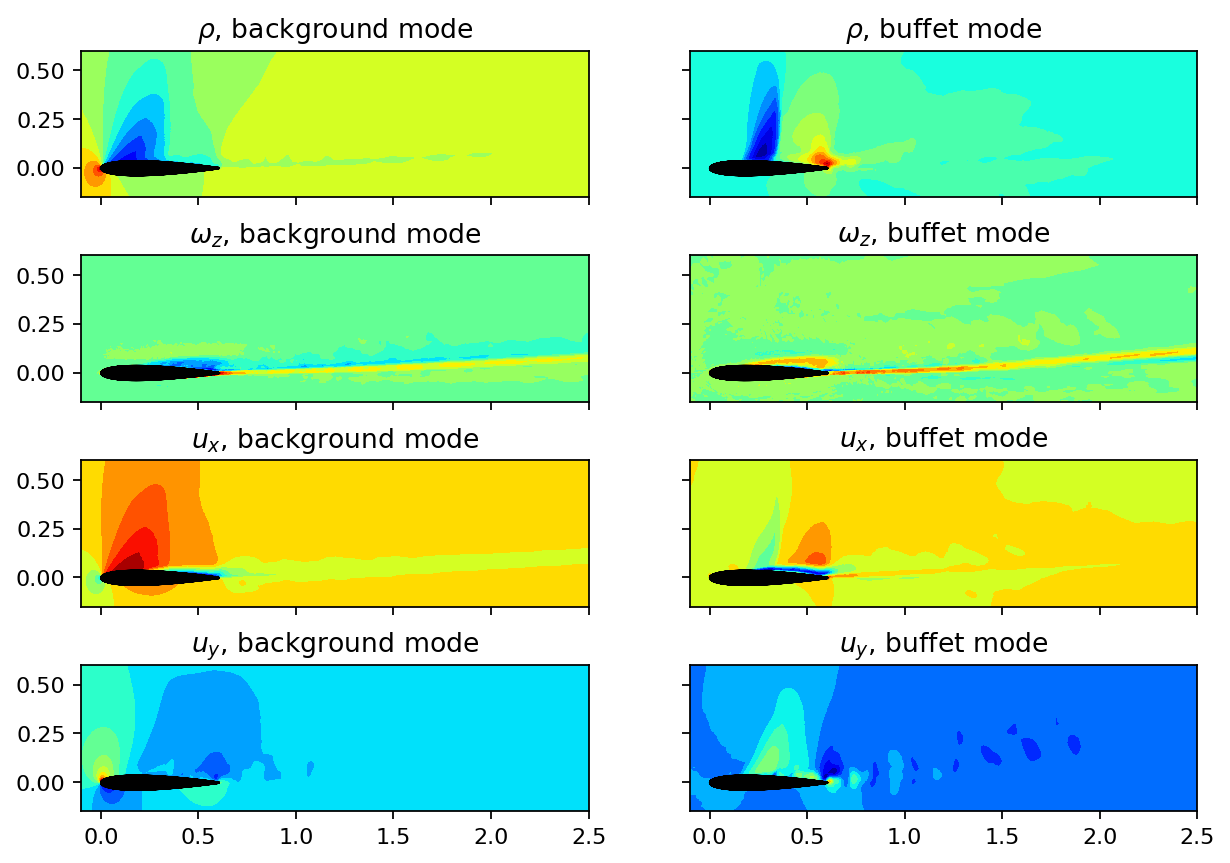

In [16]:
fig, axarr = plt.subplots(4, 2, figsize=(9, 6.5), sharex=True, sharey=True)
#fig, axarr = plt.subplots(6, 2, figsize=(8, 8), sharex=True, sharey=True)

# rho
axarr[0, 0].tricontourf(x[::every], y[::every], dmd["rho"].modes[:, 0].real[::every], levels=15, cmap="jet")
#axarr[0, 0].tricontour(x[::every], y[::every], dmd["rho"].modes[:, 0].real[::every], levels=15, linewidths=0.1, colors='k')
axarr[0, 1].tricontourf(x[::every], y[::every], dmd["rho"].modes[:, 1].real[::every], levels=15, cmap="jet")
#axarr[0, 1].tricontour(x[::every], y[::every], dmd["rho"].modes[:, 1].real[::every], levels=15, linewidths=0.1, colors='k')
# vorticity
axarr[1, 0].tricontourf(x[::every], y[::every], dmd["vorticity"].modes[:, 9].real[::every], levels=15, cmap="jet")
#axarr[1, 0].tricontour(x[::every], y[::every], dmd["vorticity"].modes[:, 9].real[::every], levels=15, linewidths=0.1, colors='k')
axarr[1, 1].tricontourf(x[::every], y[::every], dmd["vorticity"].modes[:, 10].real[::every], levels=15, cmap="jet")
#axarr[1, 1].tricontour(x[::every], y[::every], dmd["vorticity"].modes[:, 10].real[::every], levels=15, linewidths=0.1, colors='k')
# U_x
axarr[2, 0].tricontourf(x[::every], y[::every], dmd["U"].modes[:n_mask, 0].real[::every], levels=15, cmap="jet")
#axarr[2, 0].tricontour(x[::every], y[::every], dmd["U"].modes[:n_mask, 0].real[::every], levels=15, linewidths=0.1, colors='k')
axarr[2, 1].tricontourf(x[::every], y[::every], dmd["U"].modes[:n_mask, 1].real[::every], levels=15, cmap="jet")
#axarr[2, 1].tricontour(x[::every], y[::every], dmd["U"].modes[:n_mask, 1].real[::every], levels=15, linewidths=0.1, colors='k')
# U_y
axarr[3, 0].tricontourf(x[::every], y[::every], dmd["U"].modes[n_mask:, 0].real[::every], levels=15, cmap="jet")
#axarr[3, 0].tricontour(x[::every], y[::every], dmd["U"].modes[n_mask:, 0].real[::every], levels=15, linewidths=0.1, colors='k')
axarr[3, 1].tricontourf(x[::every], y[::every], dmd["U"].modes[n_mask:, 1].real[::every], levels=15, cmap="jet")
#axarr[3, 1].tricontour(x[::every], y[::every], dmd["U"].modes[n_mask:, 1].real[::every], levels=15, linewidths=0.1, colors='k')
# U_x base
#axarr[4, 0].tricontourf(x[::every], y[::every], dmd["U_base"].modes[:n_mask, 0].real[::every], levels=15, cmap="jet")
#axarr[4, 0].tricontour(x[::every], y[::every], dmd["U_base"].modes[:n_mask, 0].real[::every], levels=15, linewidths=0.1, colors='k')
#axarr[4, 1].tricontourf(x[::every], y[::every], dmd["U_base"].modes[:n_mask, 1].real[::every], levels=15, cmap="jet")
#axarr[4, 1].tricontour(x[::every], y[::every], dmd["U_base"].modes[:n_mask, 1].real[::every], levels=15, linewidths=0.1, colors='k')
# U_y base
#axarr[5, 0].tricontourf(x[::every], y[::every], dmd["U_base"].modes[n_mask:, 0].real[::every], levels=15, cmap="jet")
#axarr[5, 0].tricontour(x[::every], y[::every], dmd["U_base"].modes[n_mask:, 0].real[::every], levels=15, linewidths=0.1, colors='k')
#axarr[5, 1].tricontourf(x[::every], y[::every], dmd["U_base"].modes[n_mask:, 1].real[::every], levels=15, cmap="jet")
#axarr[5, 1].tricontour(x[::every], y[::every], dmd["U_base"].modes[n_mask:, 1].real[::every], levels=15, linewidths=0.1, colors='k')

labels = [r"$\rho$", r"$\omega_z$", r"$u_x$", r"$u_y$"]
for row in range(len(axarr[:, 0])):
    for col in range(2):
        add_naca0012_patch(axarr[row, col])
        axarr[row, col].set_aspect("equal", 'box')
        axarr[row, col].set_xlim([-0.1, 2.5])
        axarr[row, col].set_ylim([-0.15, 0.6])
        if col == 0:
            axarr[row, col].set_title(labels[row] + ", background mode")
        else:
            axarr[row, col].set_title(labels[row] + ", buffet mode")
plt.savefig("dmd_modes.pdf", bbox_inches="tight")
plt.show()

### Comparing several modes of the velocity fields with and without reference flow subtracted

Subtracting a reference flow from the velocity field changes the steady background mode. However, all remaining modes are almost exactly the same.

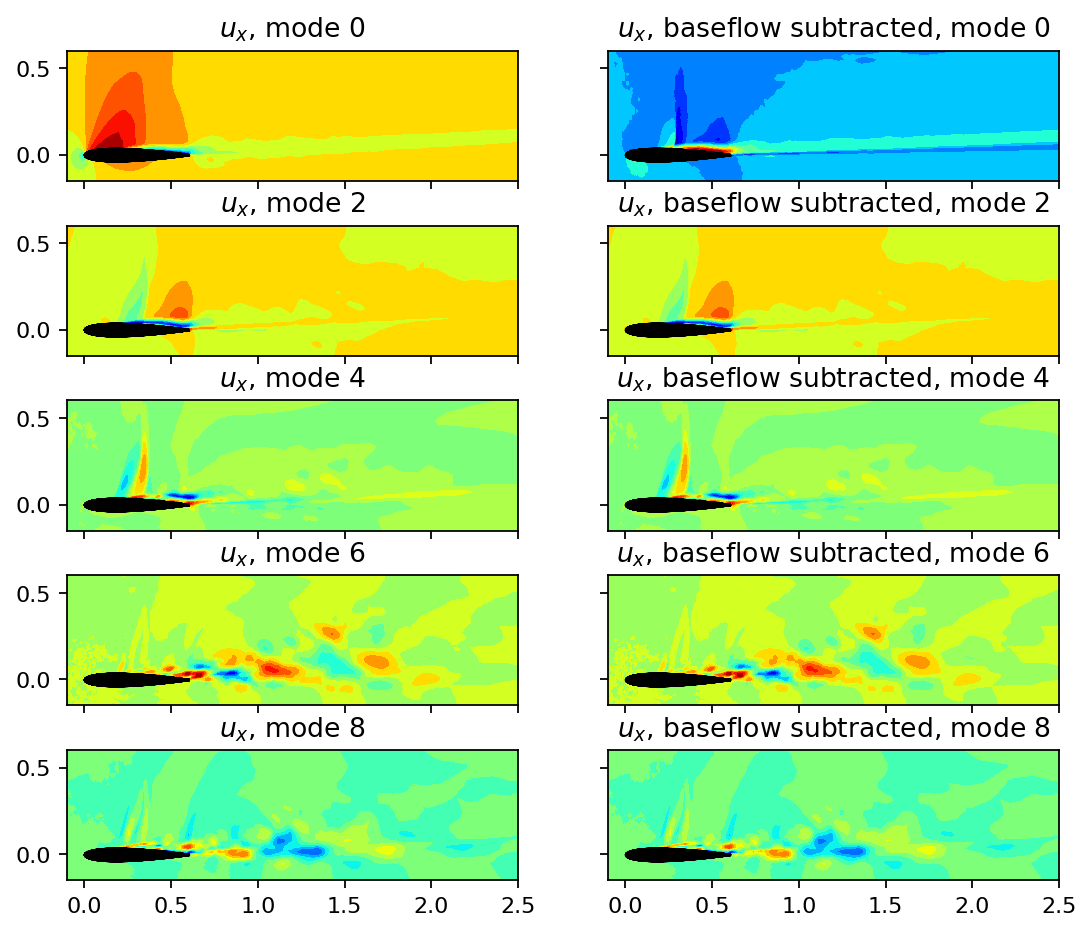

In [17]:
fig, axarr = plt.subplots(5, 2, figsize=(8, 7), sharex=True, sharey=True)
count = 0
for row in range(5):
    axarr[row, 0].tricontourf(x[::every], y[::every], dmd["U"].modes[:n_mask, count].real[::every], levels=15, cmap="jet")
    axarr[row, 1].tricontourf(x[::every], y[::every], dmd["U_base"].modes[:n_mask, count].real[::every], levels=15, cmap="jet")
    add_naca0012_patch(axarr[row, 0])
    add_naca0012_patch(axarr[row, 1])
    axarr[row, 0].set_aspect("equal", 'box')
    axarr[row, 1].set_aspect("equal", 'box')
    axarr[row, 0].set_xlim([-0.1, 2.5])
    axarr[row, 0].set_ylim([-0.15, 0.6])
    axarr[row, 1].set_xlim([-0.1, 2.5])
    axarr[row, 1].set_ylim([-0.15, 0.6])
    axarr[row, 0].set_title(r"$u_x$, mode {:d}".format(count))
    axarr[row, 1].set_title(r"$u_x$, baseflow subtracted, mode {:d}".format(count))
    count += 2
plt.show()

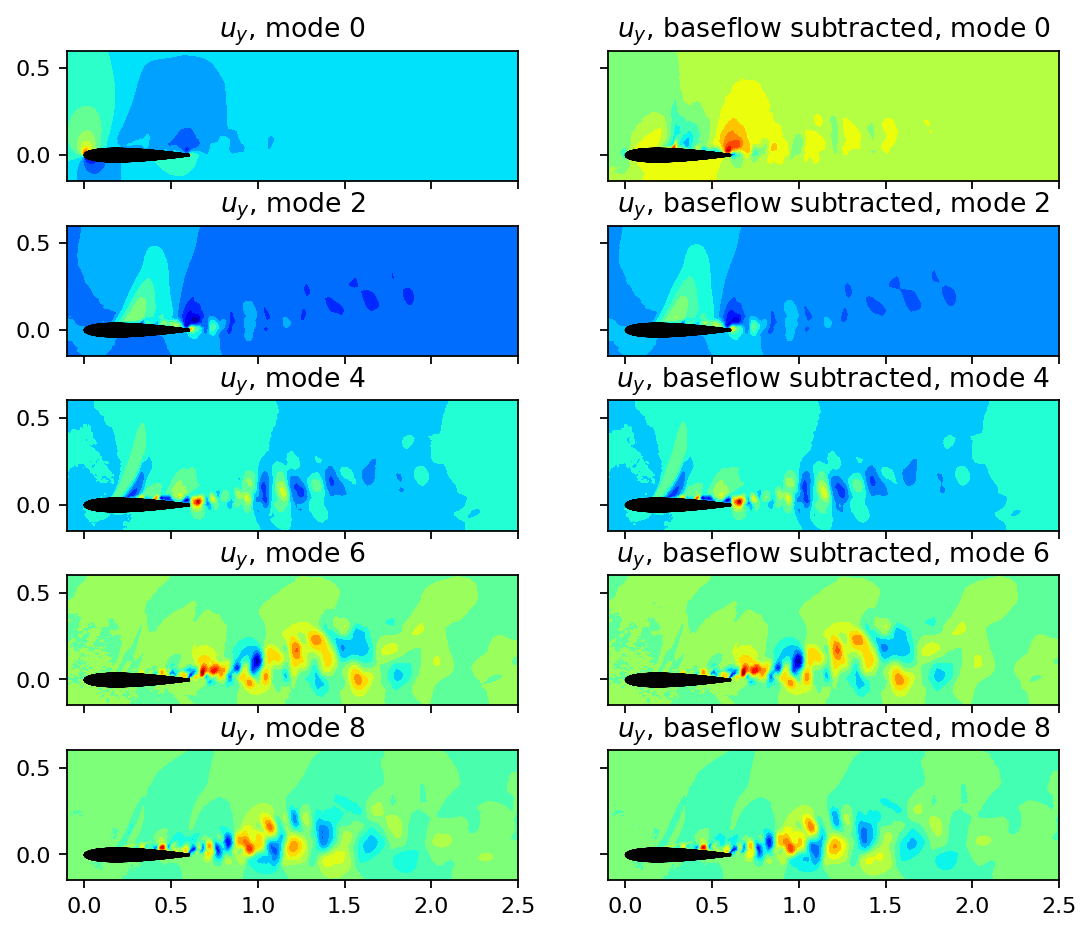

In [18]:
fig, axarr = plt.subplots(5, 2, figsize=(8, 7), sharex=True, sharey=True)
count = 0
for row in range(5):
    axarr[row, 0].tricontourf(x[::every], y[::every], dmd["U"].modes[n_mask:, count].real[::every], levels=15, cmap="jet")
    axarr[row, 1].tricontourf(x[::every], y[::every], dmd["U_base"].modes[n_mask:, count].real[::every], levels=15, cmap="jet")
    add_naca0012_patch(axarr[row, 0])
    add_naca0012_patch(axarr[row, 1])
    axarr[row, 0].set_aspect("equal", 'box')
    axarr[row, 1].set_aspect("equal", 'box')
    axarr[row, 0].set_xlim([-0.1, 2.5])
    axarr[row, 0].set_ylim([-0.15, 0.6])
    axarr[row, 1].set_xlim([-0.1, 2.5])
    axarr[row, 1].set_ylim([-0.15, 0.6])
    axarr[row, 0].set_title(r"$u_y$, mode {:d}".format(count))
    axarr[row, 1].set_title(r"$u_y$, baseflow subtracted, mode {:d}".format(count))
    count += 2
plt.show()